In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import lmfit

parent_parent_dir = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(parent_parent_dir)
import scresonators.src as scres
import scresonators.src.plotter as plotter

# from bcqt-ctrl repo
# import helper_functions as hf

from pathlib import Path
from time import sleep, time
# from tqdm.auto import tqdm


In [2]:
# only S21 dBm has factor of 20, otherwise it'd be a factor of 10
# this is because P = V^2/R, so the V^2 gives an extra factor of 2

def s21_dbm_to_lin(dbm_ampl):
    return np.log10(dbm_ampl) * 20  

def s21_lin_to_dbm(lin_ampl):
    return 10**(lin_ampl/20)

def load_csv(path):
    
    # Load the CSV file into a pandas DataFrame
    df = pd.read_csv(path, header=None)
    freqs = df[0].to_numpy()
    amps_dB = df[1].to_numpy()
    phases_init = df[2].to_numpy()

    max_phase_value = np.max(phases_init)
    min_phase_value = np.min(phases_init)
    if (max_phase_value > 2 * np.pi) or (min_phase_value < -2 * np.pi): #check if phases are in degrees or radians, convert as needed
        #phases are in degrees, we need to convert
        phases_new = np.unwrap(np.deg2rad(phases_init))
    else:
        #phases are in radians, good to go
        phases_new = np.unwrap(phases_init)

    return freqs, amps_dB, phases_new

def load_all_csvs_in_path(path, key='*', idx=None):
    """AI is creating summary for load_all_csvs_in_path

    Args:
        path ([type]): [description]
        key (str, optional): [description]. Defaults to '*'.
        idx ([type], optional): [description]. Defaults to None.

    Returns:
        [type]: [description]
    """
    data_files = glob.glob(path + key)
    
    if idx is not None:  # user wants to load a single file from dir
        idx = 0 if len(data_files) == 1 else idx  # set idx to 0 if there's only one file
        file = data_files[idx]
        df = pd.read_csv(file, sep=",", names=['Frequency','dBm','Phase'])
        freq = np.array(df['Frequency'])
        ampl = s21_lin_to_dbm(df['dBm'])
        phase = np.unwrap(np.deg2rad(df['Phase']))
        cmplx = ampl * np.exp(1j*phase)
        
        return freq, cmplx, df
    
    elif idx is None and len(data_files) != 1:  
        freq_dict, cmplx_dict, df_dict = {}, {}, {}
        for filepath in data_files:
            filename = os.path.basename(filepath)
            df = pd.read_csv(filepath, sep=",", names=['Frequency','dBm','Phase'])
            freq = np.array(df['Frequency'])
            ampl = s21_lin_to_dbm(df['dBm'])
            phase = np.unwrap(np.deg2rad(df['Phase']))
            cmplx = ampl * np.exp(1j*phase)
            
            freq_dict[filename] = freq
            cmplx_dict[filename] = cmplx
            df_dict[filename] = df
            
        return freq_dict, cmplx_dict, df_dict
        
    else:
        # idx is None and len(data_files) == 1
        print(f"idx={idx}, len(data_files)={len(data_files)}\n failed if & elif")
        raise
        
def preprocess_csv(file_path):
    """
    Preprocess a CSV file into a DataFrame. The CSV file is read starting from line 6,
    and the data in the first column is separated into respective columns by spaces.

    Parameters:
    file_path (str): Path to the input CSV file.

    Returns:
    pd.DataFrame: Preprocessed DataFrame with separated columns.
    """
    # Read the CSV file starting from line 6
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Extract the headers (assuming the first row from line 6 contains headers)
    headers = lines[5].strip().split()
    
    # Extract the data starting from line 7
    data = [line.strip().split() for line in lines[6:]]
    
    # Create a DataFrame
    df = pd.DataFrame(data, columns=headers)

    df = df.astype(float)

    return df


# load data from sample directory
data_path = 'test_data/Cooldown53/Line3_NWNb2O5_15_01/NWNb2O5_15_01_5p757GHz/NWNb2O5_15_01_5p757GHz_-43dB_11mK_homophasal.csv'

freqs, amps_dB, phases = load_csv(data_path)
# print(df)
phases = np.unwrap(phases)
amps_linear = 10 ** (amps_dB / 20)
# print(freqs)
# print(amps_dB)
# print(phases)
cmplx = amps_linear * np.exp(1j*phases)
# print(cmplx)

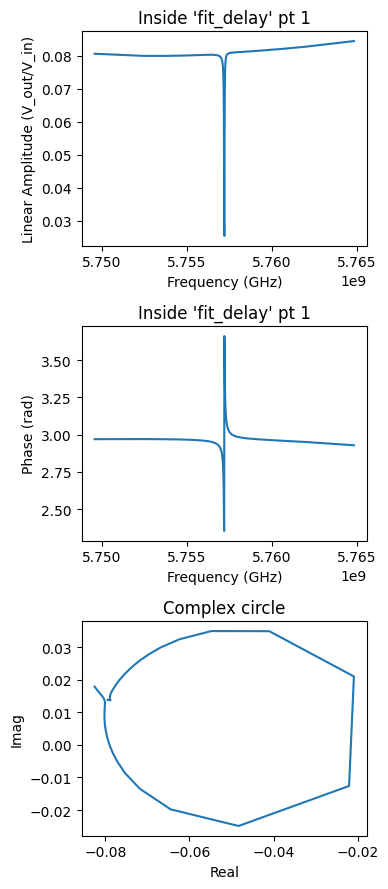

In [3]:
plt.figure(figsize=(4, 9))

plt.subplot(3,1,1)
plt.plot(freqs, amps_linear)
plt.xlabel('Frequency (GHz)')
plt.ylabel('Linear Amplitude (V_out/V_in)')
plt.title("Inside 'fit_delay' pt 1")

plt.subplot(3,1,2)
plt.plot(freqs, phases)
plt.xlabel('Frequency (GHz)')
plt.ylabel('Phase (rad)')
plt.title("Inside 'fit_delay' pt 1")       

plt.subplot(3,1,3)
plt.plot(cmplx.real, cmplx.imag)
plt.xlabel('Real')
plt.ylabel('Imag')
plt.title('Complex circle')

plt.tight_layout()

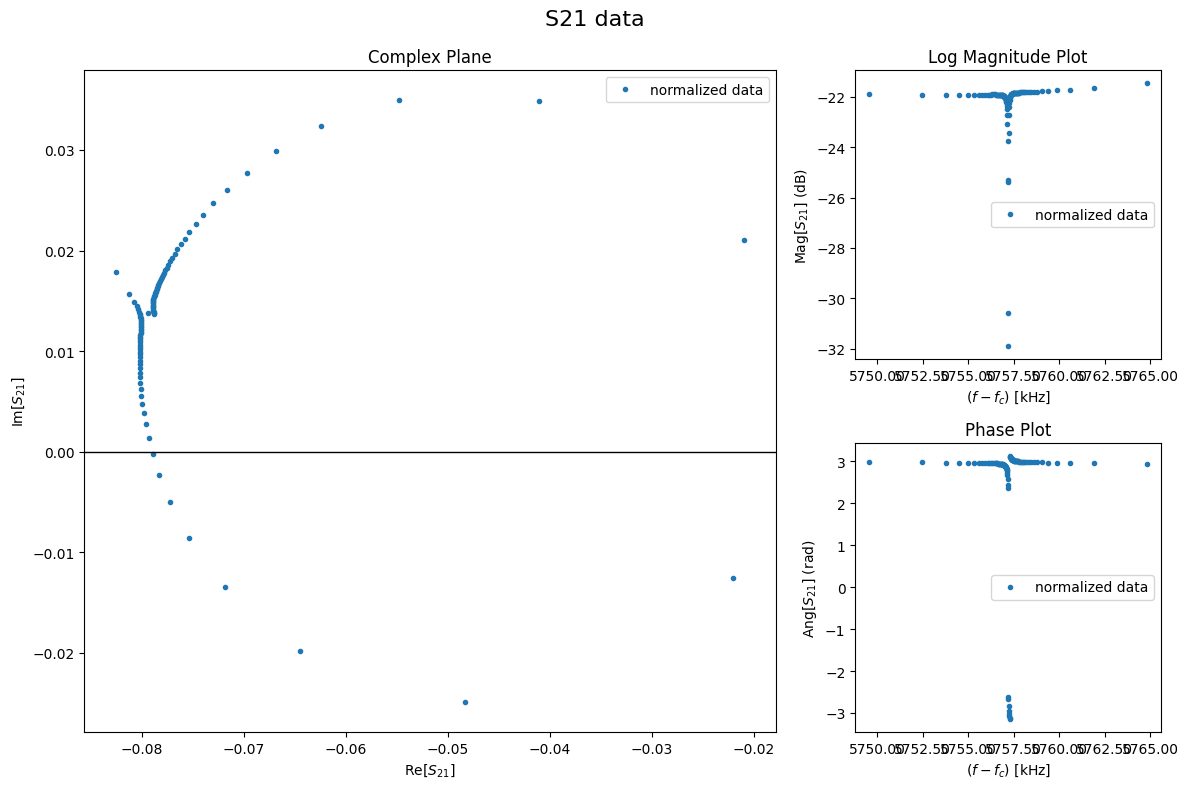

In [4]:
plot = plotter.Plotter(freqs, cmplx)

plot.plot_before_fit()

## Testing scresonators

In [5]:
dcm_method = scres.DCM()
FitRes = scres.Fitter(dcm_method)

w1 = freqs[np.abs(cmplx).argmin()]
init_guess = {
    'Q' : {'value' : 1e6, 'min' : 1e3, 'max' : 1e9},
    'Qc' : {'value' : 1e5, 'min' : 1e3, 'max' : 1e9},
    'w1' : {'value' : w1, 'min' : w1-3e3, 'max' : w1+3e3, 'vary' : True},
    'phi' : {'value' : 0.08, 'min' : -np.pi/2, 'max' : np.pi/2}, 
}

init_params = lmfit.create_params(**init_guess)
init_params.pretty_print()
print()

amps = np.abs(cmplx)
db_amps = np.log10(amps) * 20

phases = np.angle(cmplx)
result, conf_intervals, normalized_cmplx_data = FitRes.fit(freqs, db_amps, phases, manual_init=init_params, verbose=False)

fit_result_params = result.params

cmplx_fit = result.eval(params=fit_result_params, x=freqs) 

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
Q       1e+06     1000    1e+09     None     True     None     None
Qc      1e+05     1000    1e+09     None     True     None     None
phi      0.08   -1.571    1.571     None     True     None     None
w1   5.757e+09 5.757e+09 5.757e+09     None     True     None     None

Delay from 'fit_delay':  -0.07420443554951989 ns


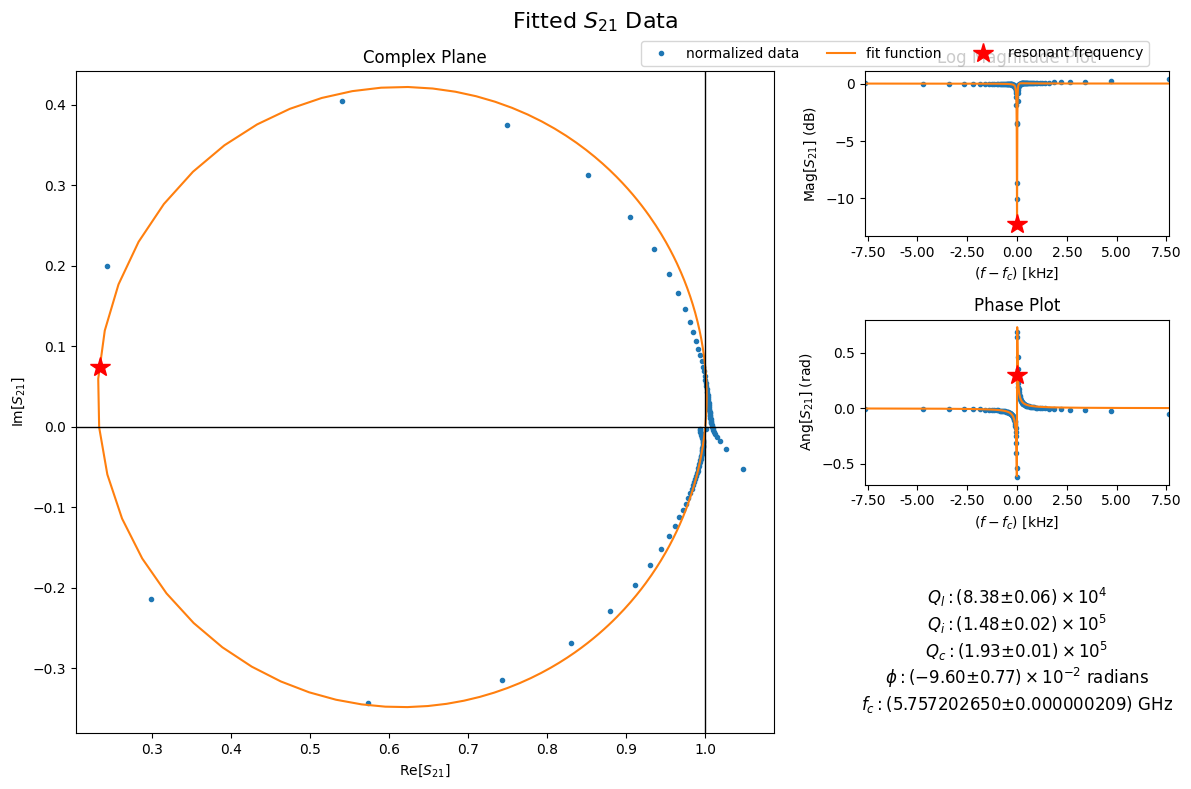

In [6]:
plot1, ax_dict = plot.plot_dcm(normalized_cmplx_data, fit_result_params, dcm_method, linear=False, num_fit_points = 10000)

## Multiple Resonators

to be implemented

In [7]:
# # load data from Andre
# data_dir = './samples/R0_Jorge/'
# chosen_files = '*'

# freq_dict, cmplx_dict = load_csv(data_dir, chosen_files, idx=None)

# dQ_list, Q_list = [], []

# print(f"# of resonators: {len(freq_dict)}")

# for freq, cmplx in zip(freq_dict.values(), cmplx_dict.values()):

#     FitRes = scres.Fitter(scres.fit_methods.DCM)

#     w1 = freq[np.abs(cmplx).argmin()]
#     init_guess = {
#         'Q' : {'value' : 1e6, 'min' : 1e3, 'max' : 1e9},
#         'Qc' : {'value' : 1e5, 'min' : 1e3, 'max' : 1e9},
#         'w1' : {'value' : w1, 'min' : w1-3e3, 'max' : w1+3e3, 'vary' : True},
#         'phi' : {'value' : 0.08, 'min' : -np.pi/2, 'max' : np.pi/2}, 
#     }

#     init_params = lmfit.create_params(**init_guess)

#     amps = np.abs(cmplx)
#     db_amps = np.log10(amps) * 20

#     phases = np.angle(cmplx)
#     result, conf_intervals = FitRes.fit(freq, db_amps, phases, manual_init=init_params, verbose=True)

#     fit_params = result.params
        
#     y_fit = result.eval(params=fit_params, x=freq)
#     # y_fit_err = result.eval_uncertainty()
#     Q_val = fit_params["Q"].value
#     Q_err = fit_params["Q"].stderr
#     dQ = 100 * Q_err/Q_val
#     print(dQ, Q_val, Q_err)
    
#     dQ_list.append(dQ)
#     Q_list.append(Q_val)


    

In [8]:
# for dQ, Q in zip(dQ_list, Q_list):
    
#     print(f"{dQ:1.2f}, {Q:1.2f}")

# fig, axes = plt.subplots(2,1, figsize=(7,8), sharex=True)
# ax1, ax2 = axes[0], axes[1]

# ax1.plot(dQ_list, 'ro', label="dQ")
# ax1.set_title(r"dQ Values  ($dQ=100 * dQ/\sigma dQ$)")

# ax2.plot(Q_list, 'bo', label="Fit")
# ax2.set_title("Q Values")

# ax2.set_xlabel("Resonator #")